# Fruit and Vegetable Image Processing


In [1]:
#importing required libraries
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
# Load the Drive helper and mount
#from google.colab import drive
import xarray as x

# 1. Loading and preprocessing<a class="anchor" id="1"></a><a class="anchor" id="1"></a>

In [2]:
import os

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
mountdir = '/content/drive'
drive.mount(mountdir, force_remount=True)

localdir = mountdir + '/MyDrive'
# Replace your folder here
w281_directory = '/Berkeley/w281/Fruit-and-Vegetable-Classification/'
inputdir = localdir + w281_directory
# Uncomment below if using local folder
# inputdir = "/Users/mcliston/Library/CloudStorage/GoogleDrive-michael.c.liston@gmail.com/My Drive/Berkeley/w281/Fruit-and-Vegetable-Classification/"

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import cv2
#import tensorflow as tf

# Create a list with the filepaths for training and testing
train_dir = Path(inputdir, './input/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path(inputdir, './input/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path(inputdir, './input/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

# Filter only selected class

In [4]:
# Fruits - banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango.
# Vegetables - Bell Pepper, Cauliflower, Chilli Pepper, Peas, Corn, Spinach, Turnip, Garlic, Ginger, Cabbage
Fruits = ['banana', 'apple', 'pear', 'grapes', 'orange', 'kiwi', 'watermelon', 'pomegranate', 'pineapple', 'mango']
Vegetables = ['bell pepper', 'cauliflower', 'chilli pepper', 'peas', 'corn', 'spinach', 'turnip', 'garlic', 'ginger', 'cabbage']

train_df = train_df[train_df['Label'].isin(Fruits + Vegetables)]
test_df = test_df[test_df['Label'].isin(Fruits + Vegetables)]
val_df = val_df[val_df['Label'].isin(Fruits + Vegetables)]

In [5]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 1540

Number of different labels: 20

Labels: ['orange' 'chilli pepper' 'pineapple' 'corn' 'watermelon' 'apple'
 'cabbage' 'spinach' 'turnip' 'mango' 'peas' 'kiwi' 'pear' 'bell pepper'
 'garlic' 'cauliflower' 'pomegranate' 'banana' 'grapes' 'ginger']


# Feature Extraction

### Color and Edge Detection functions

In [21]:
RANDOM_SEED = 1234
IMG_DIM = 512
PCA_DIM = 64

def find_edges(img):

  # converting to gray scale
  gray = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2GRAY)

  # remove noise
  img = cv2.GaussianBlur(gray,(3,3),0)

  # convolve with proper kernels
  laplacian = cv2.Laplacian(img,cv2.CV_32F)
  sobelx = cv2.Sobel(img,cv2.CV_32F,1,0,ksize=5)  # x
  sobely = cv2.Sobel(img,cv2.CV_32F,0,1,ksize=5)  # y

  return laplacian, sobelx, sobely

def get_color_features(im):

  img_512 = resize(im, (512, 512), anti_aliasing=True).astype(np.float32)
  hsv_image = cv2.cvtColor(img_512, cv2.COLOR_RGB2HSV)

  hue_channel = hsv_image[:, :, 0]
  saturation_channel = hsv_image[:, :, 1]
  value_channel = hsv_image[:, :, 2]

  return hue_channel, saturation_channel, value_channel


def image_processing(path):

    img = imread(path)


    resized_img = resize(img, (IMG_DIM,IMG_DIM), anti_aliasing=True)

    #creating hog features

    fd, hog_image = hog(resized_img, orientations=8, pixels_per_cell=(8,8),
                        cells_per_block=(4,4), visualize=True, channel_axis=-1)


    # creating edge features
    laplacian, sobelx, sobely = find_edges(resized_img)

    # creating color features
    hue_channel, saturation_channel, luminance_channel = get_color_features(resized_img)

    feature_lst = [hog_image, hue_channel, saturation_channel, luminance_channel, laplacian, sobelx, sobely]

    resized_features = [resize(z, (PCA_DIM, PCA_DIM), anti_aliasing=True) for z in feature_lst]

    return resized_features


In [10]:
RANDOM_SEED = 1234

train_set = train_df.sample(frac=0.9, random_state=RANDOM_SEED)
val_set = train_df[~(train_df.index.isin(train_set.index))]
test_set = val_df



In [17]:
np.array((10,10))

array([10, 10])

In [22]:
train_labels = []
train_dict = {
    'HOG': np.array([]),
    'Hue': np.array([]),
    'Saturation': np.array([]),
    'Luminance': np.array([]),
    'Laplacian': np.array([]),
    'Sobel_X': np.array([]),
    'Sobel_Y': np.array([])
}

hog_lst, hue_lst, sat_lst, lum_lst, lap_lst, sob_x_lst, sob_y_lst = [],[],[],[],[],[],[]

for i,j in enumerate(train_set.iterrows()):
  print(f"Processing image #: {i}")
  filepath = j[1]['Filepath']
  try:
    features = image_processing(filepath)
  except Exception as e:
    print(f"There was an {e.__class__.__name__} error while trying to process an image... continuing")
    print(f"The error occurred at image #{i}, {filepath}")
    continue

  for k,l in enumerate([hog_lst,hue_lst,sat_lst,lum_lst,lap_lst,sob_x_lst,sob_y_lst]):
    l.append(features[k].reshape(-1).astype(float))


Processing image #: 0
Processing image #: 1
Processing image #: 2
Processing image #: 3
Processing image #: 4
Processing image #: 5
Processing image #: 6
Processing image #: 7
Processing image #: 8
Processing image #: 9
Processing image #: 10
Processing image #: 11
Processing image #: 12
Processing image #: 13
Processing image #: 14
Processing image #: 15
Processing image #: 16
Processing image #: 17
Processing image #: 18
Processing image #: 19
Processing image #: 20
Processing image #: 21
Processing image #: 22
Processing image #: 23
Processing image #: 24
Processing image #: 25
Processing image #: 26
Processing image #: 27
Processing image #: 28
Processing image #: 29
Processing image #: 30
Processing image #: 31
Processing image #: 32
Processing image #: 33
Processing image #: 34
Processing image #: 35
Processing image #: 36
Processing image #: 37
Processing image #: 38
Processing image #: 39
Processing image #: 40
Processing image #: 41
Processing image #: 42
Processing image #: 4

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Processing image #: 1148
Processing image #: 1149
Processing image #: 1150
Processing image #: 1151
Processing image #: 1152
Processing image #: 1153
Processing image #: 1154
Processing image #: 1155
Processing image #: 1156
Processing image #: 1157
Processing image #: 1158
Processing image #: 1159
Processing image #: 1160
Processing image #: 1161
Processing image #: 1162
Processing image #: 1163
Processing image #: 1164
Processing image #: 1165
Processing image #: 1166
Processing image #: 1167
Processing image #: 1168
Processing image #: 1169
Processing image #: 1170
Processing image #: 1171
Processing image #: 1172
Processing image #: 1173
Processing image #: 1174
Processing image #: 1175
Processing image #: 1176
Processing image #: 1177
Processing image #: 1178
Processing image #: 1179
Processing image #: 1180
Processing image #: 1181
Processing image #: 1182
Processing image #: 1183
Processing image #: 1184
Processing image #: 1185
Processing image #: 1186
Processing image #: 1187


In [47]:
for i in [hog_lst, hue_lst, sat_lst, lum_lst, lap_lst, sob_x_lst, sob_y_lst]:
  print(len(i))

1385
1385
1385
1385
1385
1385
1385


In [33]:
# hog_lst, hue_lst, sat_lst, lum_lst, lap_lst, sob_x_lst, sob_y_lst

hog_arr = np.vstack(hog_lst)
hue_arr = np.vstack(hue_lst)
sat_arr = np.vstack(sat_lst)
lum_arr = np.vstack(lum_lst)
lap_arr = np.vstack(lap_lst)
sob_x_arr = np.vstack(sob_x_lst)
sob_y_arr = np.vstack(sob_y_lst)

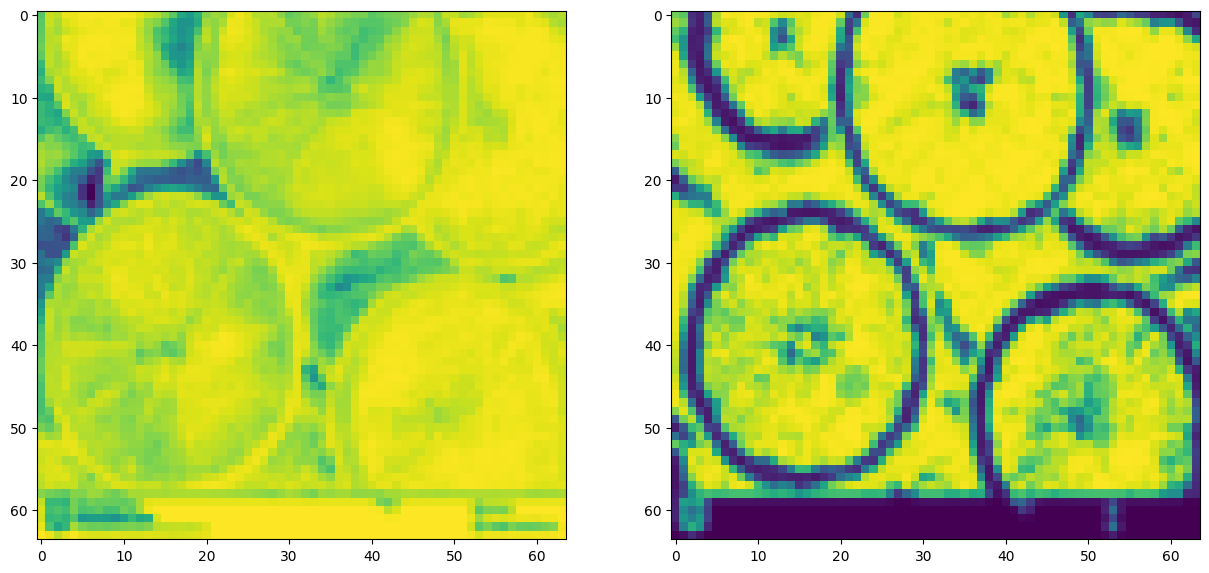

In [56]:
fig, (ax,ax1) = plt.subplots(1,2, figsize=(15,10))
test = lum_arr[1147,:]
ax.imshow(test.reshape((64,64)))

test2 = sat_arr[1147, :]
ax1.imshow(test2.reshape((64,64)))


bell pepper


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


orange


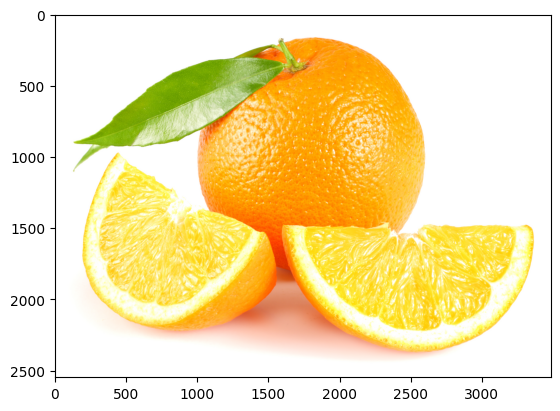

In [30]:
# exclude image at index #643 and #1147
for i,j in enumerate(train_set.iterrows()):
  if i in (643, 1147):
    filepath = j[1]['Filepath']
    label = j[1]['Label']
    im3 = imread(filepath)
    plt.imshow(im3)
    print(label)

In [26]:
hog_arr.shape

(1385, 4096)

In [13]:
im2 = imread(train_df['Filepath'].iloc[1])

In [14]:
tmp = image_processing(train_df['Filepath'].iloc[1])

In [16]:
tmp[0].reshape(-1).astype(float).shape

(4096,)

## Generate Sample Images of Edges

In [7]:
train_df.head()

,Filepath,Label
2,/content/drive/MyDrive/Berkeley/w281/Fruit-and...,orange
3,/content/drive/MyDrive/Berkeley/w281/Fruit-and...,cauliflower
4,/content/drive/MyDrive/Berkeley/w281/Fruit-and...,mango
5,/content/drive/MyDrive/Berkeley/w281/Fruit-and...,corn
8,/content/drive/MyDrive/Berkeley/w281/Fruit-and...,watermelon


In [ ]:
img_dim = 512

unique_df = train_df.drop_duplicates(['Label'])
vertical_layout_split = 5
n_rows = vertical_layout_split
n_cols = 4

for index, item in enumerate(unique_df.iterrows()):

  row = item[1]
  filepath = row['Filepath']
  label = row['Label']

  # reading the image
  img = imread(filepath)
  resized_img = resize(img, (img_dim, img_dim), anti_aliasing=True)

  #creating edge features
  laplacian, sobelx, sobely = find_edges(resized_img)

  # Prepare
  if index % vertical_layout_split == 0:
    f, axarr = plt.subplots(n_rows, n_cols, figsize=(10, 16))
    plt.subplots_adjust(wspace=0, hspace=0)



## Constructing Feature Vectors

# PCA

In [ ]:
# Import required modules
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plotPCA(df, n_components=50, feature='Type of Feature'):
  pca = PCA(n_components=min(df.count(), n_components))

  # Perform fit
  converted_data = pca.fit(df.tolist())

  PC_values = np.arange(pca.n_components_) + 1
  plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), 'o-', linewidth=2, color='blue')
  plt.bar(PC_values, np.cumsum(pca.explained_variance_ratio_), color ='maroon',
          width = 0.4)
  plt.ylim(0.0,1.05)
  plt.legend([feature])
  plt.xlabel('Principal Component')
  plt.ylabel('Variance Explained')
  plt.show()

In [ ]:
img_dim = 512
pca_dim = 64 # Resize to 64 due to expensive calculation on PCA

train_df_features = pd.DataFrame(train_df,columns=['Filepath', 'Label', 'HOG', 'Hue', 'Saturation', 'Luminance', 'Laplacian', 'Sobel_X', 'Sobel_Y'], dtype=object)

count = 0
# Set this lower to make it run faster, for example 10
num_examples = 100
for index, item in enumerate(train_df.iterrows()):
  if count >= num_examples:
    break
  count += 1
  row = item[1]
  filepath = row['Filepath']
  label = row['Label']

  # reading the image
  img = imread(filepath)

  resized_img = resize(img, (img_dim, img_dim), anti_aliasing=True)

  #creating hog features
  fd, hog_image = hog(resized_img, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(4, 4), visualize=True, channel_axis=-1)

  # creating edge features
  laplacian, sobelx, sobely = find_edges(resized_img)

  # creating color features
  hue_channel, saturation_channel, luminance_channel = get_color_features(resized_img)

  resized_hog_img = resize(hog_image, (pca_dim, pca_dim), anti_aliasing=True)
  resized_hue_img = resize(hue_channel, (pca_dim, pca_dim), anti_aliasing=True)
  resized_saturation_img = resize(saturation_channel, (pca_dim, pca_dim), anti_aliasing=True)
  resized_luminance_img = resize(luminance_channel, (pca_dim, pca_dim), anti_aliasing=True)
  resized_laplacian_img = resize(laplacian, (pca_dim, pca_dim), anti_aliasing=True)
  resized_sobelx_img = resize(sobelx, (pca_dim, pca_dim), anti_aliasing=True)
  resized_sobely_img = resize(sobely, (pca_dim, pca_dim), anti_aliasing=True)

  new_entry =  {'Filepath': filepath,
                'Label': label,
                'HOG': resized_hog_img.reshape(-1).astype(float),
                'Hue': resized_hue_img.reshape(-1).astype(float),
                'Saturation': resized_saturation_img.reshape(-1).astype(float),
                'Luminance': resized_luminance_img.reshape(-1).astype(float),
                'Laplacian': resized_laplacian_img.reshape(-1).astype(float),
                'Sobel_X': resized_sobelx_img.reshape(-1).astype(float),
                'Sobel_Y': resized_sobely_img.reshape(-1).astype(float)}

  train_df_features.loc[index] = new_entry

In [ ]:
train_df_features['HOG'] = train_df_features['HOG'].apply(lambda x: x - np.mean(x))
train_df_features['Hue'] = train_df_features['Hue'] = train_df_features['Hue'].apply(lambda x: x - np.mean(x))
train_df_features['Saturation'] = train_df_features['Saturation'].apply(lambda x: x - np.mean(x))
train_df_features['Luminance'] = train_df_features['Luminance'].apply(lambda x: x - np.mean(x))
train_df_features['Laplacian'] = train_df_features['Laplacian'].apply(lambda x: x - np.mean(x))
train_df_features['Sobel_X'] = train_df_features['Sobel_X'].apply(lambda x: x - np.mean(x))
train_df_features['Sobel_Y'] = train_df_features['Sobel_Y'].apply(lambda x: x - np.mean(x))
